# Transfer Learning

В этом ноутбуке будет показана возможность использовать предобученные классификаторы для дальнейшего простого и быстрого их дообучения на нужной базе

### Зачем это нужно?
* Конечная база данных недостаточно представительна для полноценного обучения (сотни или даже десятки картинок)
* Имеется предобученная СНС на представительной БД (например, ImageNet)
* Нужно быстро получить классификатор на новой (конечной) БД

### Как это обычно делают в Keras?
* Берут предобученную СНС-классификатор
* Отрезают все слои, следующие за последним сверточным (Flatten, Dense, Softmax)
* Замораживают веса оставшихся слоев (опционально - для ускорения обучения)
* Сверху навешивают новую "голову" с нужным числом классов и своей функцией потерь
* Собирают (компилируют) новую модель и дообучают

### План
* Обучим сеть для MNIST
* Обучим сеть для Fashion MNIST 
* Сделаем Transfer Learning для MNIST -> Fashion MNIST
* Увидим, что использование этой техники даже в таком игрушечном примере может улучшать качество по сравнению с обычным обучением
* Покажем, как делать Transfer Learning для предобученных моделей на Keras 

In [1]:
import keras
import numpy as np
np.random.seed(123)  # for reproducibility
from keras.utils import np_utils

from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.layers import Conv2D
 
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Загружаем стандартные интерфейсы для работы с (Fashion) MNIST

In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

### MNIST

#### Загружаем саму базу MNIST

In [3]:
(m_x_train, m_y_train), (m_x_test, m_y_test) = mnist.load_data()

In [4]:
print(m_x_train.dtype)

uint8


In [5]:
print(m_x_train.shape, m_x_test.shape, m_y_train.shape, m_y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


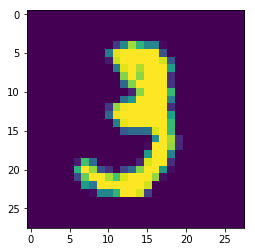

In [6]:
m_image = m_x_train[10]
plt.imshow(m_image)
plt.show()

#### Preprocessing

In [7]:
m_x_train = m_x_train.astype(np.float32)[..., np.newaxis]/255
m_x_test = m_x_test.astype(np.float32)[..., np.newaxis]/255
m_y_train = np_utils.to_categorical(m_y_train, num_classes=10)
m_y_test = np_utils.to_categorical(m_y_test, num_classes=10)

In [8]:
print(m_x_train.shape, m_x_test.shape, m_y_train.shape, m_y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


#### Конструируем простую СНС

In [9]:
m_input_image = Input(shape=(28, 28, 1))
m_conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last')(m_input_image)
m_conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last')(m_conv1)
m_flatten = Flatten()(m_conv2)
m_dense1 = Dense(128, activation='relu')(m_flatten)
m_dense2 = Dense(10, activation='softmax')(m_dense1)
m_model = Model(inputs=m_input_image, outputs=m_dense2)

Instructions for updating:
Colocations handled automatically by placer.


#### Смотрим краткую инфу по СНС

In [10]:
m_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 211,690
Trainable params: 211,690
Non-trainable params: 0
_____________________________________________________

#### Прикручиваем функцию потерь, оптимизатор и набор метрик

In [11]:
m_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Обучаем

In [12]:
m_history = m_model.fit(m_x_train, m_y_train, validation_split=0.25, batch_size=32, epochs=1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 15000 samples
Epoch 1/1
45000/45000 [==============================] - 18s 390us/step - loss: 0.1936 - accuracy: 0.9416 - val_loss: 0.0841 - val_accuracy: 0.9743


In [13]:
# Plot training & validation accuracy values
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()

#### Смотрим качество на тесте

In [14]:
m_score = m_model.evaluate(m_x_test, m_y_test, verbose=0)
print(100*m_score[1])

97.78000116348267


#### Распечатываем вектор сдвигов для сверток слоя 'conv2d_1' - их 32
* Обращаем внимание, как обращаться к слою по имени (который можно посмотреть в model.summary() )
* Обращаем внимание, как вытаскивать обучаемые веса слоя через get_weights() )
* m_c[0] - ядра сверток, m_c[1] - их сдвиги

In [15]:
m_c = m_model.get_layer('conv2d_1').get_weights()
print(m_c[1]) 

[ 5.4286174e-03  1.8854599e-03 -2.5786741e-03 -2.1220353e-03
 -9.6776537e-05  3.1758770e-02 -3.6985474e-03  1.8510371e-03
 -4.6122575e-04 -1.3554611e-03  1.2931432e-02  3.0735601e-03
 -2.0843486e-03  6.1635938e-03 -4.3726028e-03  4.9938709e-03
 -1.3935488e-03  6.2724864e-03  2.3815279e-04  7.9222466e-04
 -4.3180710e-04  5.1443849e-02  3.0634951e-02  1.4063112e-03
 -1.8424233e-03  1.9881932e-02 -1.5044523e-03  4.5948618e-05
 -2.6462940e-03  2.1636998e-03 -2.3130607e-03  3.7237839e-03]


### Fashion MNIST

Делаем все то же самое, что и для MNIST

In [16]:
(f_x_train, f_y_train), (f_x_test, f_y_test) = fashion_mnist.load_data()

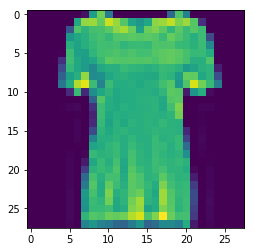

In [17]:
f_image = f_x_train[10]
plt.imshow(f_image)
plt.show()

In [18]:
f_x_train = f_x_train.astype(np.float32)[..., np.newaxis]/255
f_x_test = f_x_test.astype(np.float32)[..., np.newaxis]/255
f_y_train = np_utils.to_categorical(f_y_train, num_classes=10)
f_y_test = np_utils.to_categorical(f_y_test, num_classes=10)

In [19]:
f_input_image = Input(shape=(28, 28, 1))
f_conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last')(f_input_image)
f_conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding="same", activation='relu', data_format='channels_last')(f_conv1)
f_flatten = Flatten()(f_conv2)
f_dense1 = Dense(128, activation='relu')(f_flatten)
f_dense2 = Dense(10, activation='softmax')(f_dense1)
f_model = Model(inputs=f_input_image, outputs=f_dense2)

In [20]:
f_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 211,690
Trainable params: 211,690
Non-trainable params: 0
_____________________________________________________

In [21]:
f_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
f_history = f_model.fit(f_x_train, f_y_train, validation_split=0.25, batch_size=32, epochs=1, verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/1
45000/45000 [==============================] - 17s 384us/step - loss: 0.4653 - accuracy: 0.8332 - val_loss: 0.3400 - val_accuracy: 0.8770


In [23]:
# Plot training & validation accuracy values
#plt.plot(fhistory.history['accuracy'])
#plt.plot(fhistory.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()

In [24]:
f_score = f_model.evaluate(f_x_test, f_y_test, verbose=0)
print(100*f_score[1])

86.87000274658203


In [25]:
f_c = f_model.get_layer('conv2d_3').get_weights()
print(f_c[1])

[-0.00016893  0.00665746  0.00138501  0.08844622  0.05806929  0.01127577
  0.11452164  0.08625756  0.02335931 -0.00433461  0.03810786  0.01438208
  0.00828008  0.01911275  0.02756644  0.00785673  0.02704236  0.01009052
  0.02793615  0.02811772  0.02665378 -0.00480357  0.02036573  0.10128123
 -0.00155543  0.00641265  0.03861093  0.01480334  0.01535734  0.01004093
  0.00611961  0.00298612]


### MNIST -> Fashion MNIST  

#### Скопируем архитектуру модели MNIST (clone_model) и ее веса (set/get weights), чтобы не повредить изначальную модель

In [26]:
# скопируем модель
f2m_model = keras.models.clone_model(m_model)
f2m_model.set_weights(m_model.get_weights())
f2m_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 211,690
Trainable params: 211,690
Non-trainable params: 0
_____________________________________________________

#### Запомним вектор сдвигов

In [27]:
f2m_c = f2m_model.get_layer('conv2d_1').get_weights()
print(f2m_c[1])

[ 5.4286174e-03  1.8854599e-03 -2.5786741e-03 -2.1220353e-03
 -9.6776537e-05  3.1758770e-02 -3.6985474e-03  1.8510371e-03
 -4.6122575e-04 -1.3554611e-03  1.2931432e-02  3.0735601e-03
 -2.0843486e-03  6.1635938e-03 -4.3726028e-03  4.9938709e-03
 -1.3935488e-03  6.2724864e-03  2.3815279e-04  7.9222466e-04
 -4.3180710e-04  5.1443849e-02  3.0634951e-02  1.4063112e-03
 -1.8424233e-03  1.9881932e-02 -1.5044523e-03  4.5948618e-05
 -2.6462940e-03  2.1636998e-03 -2.3130607e-03  3.7237839e-03]


#### Убираем последние несверточные слои

In [28]:
f2m_model.layers[-3:] = []
f2m_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


#### Замораживаем сверточные слои из модели MNIST

In [29]:
for layer in f2m_model.layers:
    layer.trainable = False

#### Приделываем новую классификационную голову
* Для этого на вход новому слою Flatten подаем выход последнего сверточного слоя из новой модели, который смотрим опять из model.summary()

In [30]:
new_flatten = Flatten()(f2m_model.get_layer('conv2d_2').output)
new_dense1 = Dense(128, activation='relu')(new_flatten)
new_dense2 = Dense(10, activation='softmax')(new_dense1)

new_model = Model(inputs=f2m_model.inputs, outputs=new_dense2)

In [31]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Проверяем, что после построения новой модели веса сдвигов не поменялись

In [32]:
new_c = new_model.get_layer('conv2d_1').get_weights()
print(new_c[1])

[ 5.4286174e-03  1.8854599e-03 -2.5786741e-03 -2.1220353e-03
 -9.6776537e-05  3.1758770e-02 -3.6985474e-03  1.8510371e-03
 -4.6122575e-04 -1.3554611e-03  1.2931432e-02  3.0735601e-03
 -2.0843486e-03  6.1635938e-03 -4.3726028e-03  4.9938709e-03
 -1.3935488e-03  6.2724864e-03  2.3815279e-04  7.9222466e-04
 -4.3180710e-04  5.1443849e-02  3.0634951e-02  1.4063112e-03
 -1.8424233e-03  1.9881932e-02 -1.5044523e-03  4.5948618e-05
 -2.6462940e-03  2.1636998e-03 -2.3130607e-03  3.7237839e-03]


#### Дообучаем новую модель на Fashion MNIST

In [33]:
new_history = new_model.fit(f_x_train, f_y_train, validation_split=0.25, batch_size=32, epochs=1, verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/1
45000/45000 [==============================] - 9s 202us/step - loss: 0.4294 - accuracy: 0.8469 - val_loss: 0.3488 - val_accuracy: 0.8734


#### На всякий случай еще раз проверим, что веса сдвигов были заморожены

In [34]:
new_c = new_model.get_layer('conv2d_1').get_weights()
print(new_c[1])

[ 5.4286174e-03  1.8854599e-03 -2.5786741e-03 -2.1220353e-03
 -9.6776537e-05  3.1758770e-02 -3.6985474e-03  1.8510371e-03
 -4.6122575e-04 -1.3554611e-03  1.2931432e-02  3.0735601e-03
 -2.0843486e-03  6.1635938e-03 -4.3726028e-03  4.9938709e-03
 -1.3935488e-03  6.2724864e-03  2.3815279e-04  7.9222466e-04
 -4.3180710e-04  5.1443849e-02  3.0634951e-02  1.4063112e-03
 -1.8424233e-03  1.9881932e-02 -1.5044523e-03  4.5948618e-05
 -2.6462940e-03  2.1636998e-03 -2.3130607e-03  3.7237839e-03]


#### Сравним качество дообученной модели с исходной

In [35]:
new_score = new_model.evaluate(f_x_test, f_y_test, verbose=0)
print('Fashion model acc =', 100*f_score[1], 'MNIST->Fashion model acc =', 100*new_score[1])

Fashion model acc = 86.87000274658203 MNIST->Fashion model acc = 86.87999844551086


## Работа с предобученными моделями в Keras

Для примера возьмем легкую MobileNet, все же доступные предобученные модели можно посмотреть здесь - https://keras.io/applications/

In [36]:
from keras.applications.mobilenet import MobileNet
mobile_net = MobileNet(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=1000)

#### Важные параметры
* input_shape - (224,224,3) или (3, 224, 224) в зависимости от того, когда у вас идут каналы изображения (channels_last или channels_first)
* include_top=False - самый важный параметр, говорит о том, что нужно отрезать всю голову СНС после последней свертки
* weights='imagenet' - подгружаем веса СНС, обученной на ImageNet (classes не задаем)
* Если же хотим просто использовать архитектуру без весов, то weights=None и classes=нужное_количество

In [37]:
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

#### Заморозка слоев

In [38]:
for layer in mobile_net.layers:
    layer.trainable = False

#### Приделывание новой головы

In [39]:
x = mobile_net.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(111, activation="softmax")(x)

#### Завершение создания новой модели

In [40]:
# creating the final model 
model_final = Model(inputs = mobile_net.inputs, outputs = predictions)
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

#### Ну и дальше обучение model_final ...